In [4]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as tt
import json
import re
import string
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import Vocab
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# importing torch.optim and torch.nn.functional
import torch.optim as optim
from sklearn import datasets

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
#from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

print(torch.__version__)
print(torchvision.__version__)

# Create a SummaryWriter
writer = SummaryWriter()

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
device

2.0.1
0.15.1


device(type='mps')

In [5]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

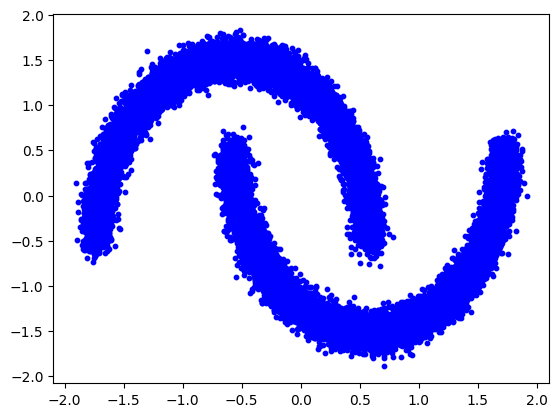

In [6]:
data = datasets.make_moons(n_samples=30000, noise=.05)[0].astype(np.float32)

scaler = StandardScaler()
data = scaler.fit_transform(data)

# converting to torch tensor
normalized_data = torch.from_numpy(data)

# plotting it on a scatter

plt.scatter(normalized_data[:, 0], normalized_data[:, 1], s=10, c='b')
plt.show()


In [9]:
class Coupling(nn.Module):
    def __init__(self, input_dim, coupling_dim, reg):
        super(Coupling, self).__init__()
        self.input_dim = input_dim
        self.coupling_dim = coupling_dim
        self.reg = reg
        
        self.s_layer_1 = nn.Linear(input_dim, coupling_dim)
        self.s_layer_2 = nn.Linear(coupling_dim, coupling_dim)
        self.s_layer_3 = nn.Linear(coupling_dim, coupling_dim)
        self.s_layer_4 = nn.Linear(coupling_dim, coupling_dim)
        self.s_layer_5 = nn.Linear(coupling_dim, input_dim)

        self.t_layer_1 = nn.Linear(input_dim, coupling_dim)
        self.t_layer_2 = nn.Linear(coupling_dim, coupling_dim)
        self.t_layer_3 = nn.Linear(coupling_dim, coupling_dim)
        self.t_layer_4 = nn.Linear(coupling_dim, coupling_dim)
        self.t_layer_5 = nn.Linear(coupling_dim, input_dim)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        s_layer_1_out = self.relu(self.s_layer_1(x))
        s_layer_2_out = self.relu(self.s_layer_2(s_layer_1_out))
        s_layer_3_out = self.relu(self.s_layer_3(s_layer_2_out))
        s_layer_4_out = self.relu(self.s_layer_4(s_layer_3_out))
        s_layer_5_out = self.tanh(self.s_layer_5(s_layer_4_out))

        t_layer_1_out = self.relu(self.t_layer_1(x))
        t_layer_2_out = self.relu(self.t_layer_2(t_layer_1_out))
        t_layer_3_out = self.relu(self.t_layer_3(t_layer_2_out))
        t_layer_4_out = self.relu(self.t_layer_4(t_layer_3_out))
        t_layer_5_out = self.t_layer_5(t_layer_4_out)

        return s_layer_5_out, t_layer_5_out
    
    def weight_decay_loss(self):
        l2_reg = torch.tensor(0.0)
        for name, param in self.named_parameters():
            if 'weight' in name:
                l2_reg += torch.norm(param, p=2)
        return self.reg * l2_reg



In [12]:
class RealNVP(nn.Module):
    def __init__(self, input_dim, coupling_layers, coupling_dim, regularization):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros(input_dim), torch.eye(input_dim)
        )
        self.masks = torch.tensor(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype=torch.float32
        )
        self.loss_tracker = nn.MSELoss()
        self.layers_list = nn.ModuleList([
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ])

    def forward(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * torch.exp(direction * s) + direction * t * torch.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * torch.sum(s, dim=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -torch.mean(log_likelihood)

In [ ]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

In [13]:
model = RealNVP(INPUT_DIM, COUPLING_LAYERS, COUPLING_DIM, REGULARIZATION)
model.to(device)

RealNVP(
  (loss_tracker): MSELoss()
  (layers_list): ModuleList(
    (0-1): 2 x Coupling(
      (s_layer_1): Linear(in_features=2, out_features=256, bias=True)
      (s_layer_2): Linear(in_features=256, out_features=256, bias=True)
      (s_layer_3): Linear(in_features=256, out_features=256, bias=True)
      (s_layer_4): Linear(in_features=256, out_features=256, bias=True)
      (s_layer_5): Linear(in_features=256, out_features=2, bias=True)
      (t_layer_1): Linear(in_features=2, out_features=256, bias=True)
      (t_layer_2): Linear(in_features=256, out_features=256, bias=True)
      (t_layer_3): Linear(in_features=256, out_features=256, bias=True)
      (t_layer_4): Linear(in_features=256, out_features=256, bias=True)
      (t_layer_5): Linear(in_features=256, out_features=2, bias=True)
      (relu): ReLU()
      (tanh): Tanh()
    )
  )
)

In [ ]:
# setting optimizer
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.001)